In [1]:
import pandas as pd
import numpy as np
from random import randint
from newspaper import Article
import re
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

from urllib.parse import urlparse
from bs4 import BeautifulSoup
import requests
import networkx as nx

In [196]:
all_news = pd.read_csv("../data/all_news.csv")
selected_news = pd.read_csv("../data/selected_articles.csv")

In [8]:
def get_external_links(url):
    domain_name = urlparse(url).netloc

    if domain_name == 't.co':
        domain_name = 'twitter'
        
    soup = BeautifulSoup(requests.get(url).content)
    text = soup.findAll('p')

    external_links = [a.attrs.get('href') for article in text for a in article.findAll('a', href=True) if domain_name not in a.attrs.get('href') and a.attrs.get('href')[0:5] == 'https']
    return external_links, domain_name

In [74]:
def add_to_adjacency_m(level, num_links, nodes, max_depth):
     # create adjacency matrix
    if (len(nodes) == 0):
        nodes.append(np.array(np.append(0, np.repeat(1, num_links))))
    else:
        prev = nodes[-1]
        children = np.repeat(1, num_links)
        if (level == max_depth):
            children = np.array([])
        insert_nodes = np.array(np.insert(np.repeat(0, len(prev)), len(prev), children))
        
        # reshape previous nodes to account for new nodes
        for i in range(0, len(nodes)):
            if (len(nodes[i]) == len(insert_nodes)):
                break
            nodes[i] = np.array(np.insert(nodes[i], len(nodes[i]), np.repeat(0, len(children))))

        nodes.append(insert_nodes)

In [170]:
MAX_DEPTH = 3
def find_source(url, level, all_sources, nodes, all_links):
    all_links.append(url)
    # get external links
    links, domain_name = get_external_links(url)

    # creates adjacency matrix from recursive function
    add_to_adjacency_m(level, len(links), nodes, MAX_DEPTH)

    # link is a source if it has no external links (base case)
    if (len(links) == 0):
        all_sources.append(url)
        return
    # depth limit base case
    if (level >= MAX_DEPTH):
        return
    # explore all external links
    level += 1
    for link in links:
        find_source(link, level, all_sources, nodes, all_links)

### This daily caller source has a really large tree 

In [190]:
sub = all_news[all_news.url.str.contains("dailycaller")]
test_url = sub[sub.title.str.contains("Rapino")].url.values[0]

In [224]:
# trying random sample
test_url = selected_news.sample(1).url.values[0]
test_url

'http://www.womensystems.com/2021/09/haitian-deportees-bite-ice-agents-and.html'

In [225]:
level = 0
sources = []
all_nodes = []
all_articles = []
find_source(test_url, level, sources, all_nodes, all_articles)

### Visualizing source structure

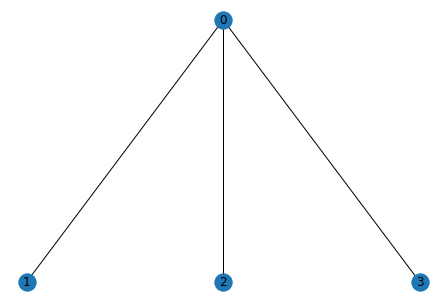

In [226]:
A = np.array(all_nodes)
G = nx.Graph(A)
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True)

In [227]:
source_keywords = []
for source in sources:
    if ("t.co" in source) or ("twitter" in source) or ("instagram" in source):
        continue
    else:
        article = Article(source)
        article.download()
        article.parse()
        article.nlp()
        source_keywords.append(article.keywords)

In [228]:
article = Article(test_url)
article.download()
article.parse()
article.nlp()
orginal_keywords = article.keywords

In [229]:
orginal_keywords

['agents',
 '24',
 'archive',
 'blog',
 '78',
 '49',
 '177',
 'flights',
 '26',
 'bite',
 '75',
 'assault',
 'deportees',
 'haitian',
 'ice',
 'portauprince',
 '218',
 'pilots',
 'deportation',
 '28']

In [230]:
source_keywords

[['flight',
  'washington',
  'officers',
  'enforcement',
  'bite',
  'ice',
  'plane',
  'federal',
  'runway',
  'rio',
  'deportation',
  'migrants',
  'haitian'],
 ['source',
  'familiar',
  'men',
  'deportees',
  'officers',
  'immigration',
  'deported',
  'security',
  'arrived',
  'assaulted',
  'pilots',
  'flights',
  'injured',
  'ice',
  'haitian'],
 ['account', 'suspended']]